In [53]:
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob
import matplotlib.pyplot as plt
from lxml import etree
import glob
from matplotlib.patches import Rectangle

# 创建输入管道

In [18]:
images = glob.glob('/Users/davidt0n/Downloads/Paper/小目标检测-深度学习/sirst-master/images/*.png')
xmls = glob.glob('/Users/davidt0n/Downloads/Paper/小目标检测-深度学习/sirst-master/masks/*.xml')

In [19]:
names = [x.split('/')[-1].split('.xml')[0] for x in xmls]
images.sort(key = lambda x:x.split('/')[-1].split('.png')[0])
xmls.sort(key = lambda x:x.split('/')[-1].split('.xml')[0])

In [20]:
train_num = int(len(images)*0.8)
test_num = len(images) - train_num
imgs_train = np.array(images[:train_num])
imgs_test = np.array(images[train_num:])

In [21]:
def to_labels(path):
        xml = open('{}'.format(path)).read()
        sel = etree.HTML(xml)
        w = int(sel.xpath('//size/width/text()')[0])
        h = int(sel.xpath('//size/height/text()')[0])
        xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
        ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
        xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
        ymax = int(sel.xpath('//bndbox/ymax/text()')[0])
        return [xmin/w, ymin/h, xmax/w, ymax/h]

In [22]:
labels = [to_labels(path) for path in xmls]
out_xmin, out_ymin, out_xmax, out_ymax = np.array(list(zip(*labels)))

In [23]:
train_labels = tf.data.Dataset.from_tensor_slices((out_xmin[:train_num], out_ymin[:train_num], out_xmax[:train_num], out_ymax[:train_num]))
test_labels = tf.data.Dataset.from_tensor_slices((out_xmin[train_num:], out_ymin[train_num:], out_xmax[train_num:], out_ymax[train_num:]))

In [24]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 1)
    img = tf.image.resize(img, [224, 224])
    img = img/127.5 - 1
    return img

In [25]:
train_imgs_datasets = tf.data.Dataset.from_tensor_slices(imgs_train)
train_imgs_datasets = train_imgs_datasets.map(load_image)

In [26]:
train_datasets = tf.data.Dataset.zip((train_imgs_datasets, train_labels))
train_datasets

<ZipDataset shapes: ((224, 224, 1), ((), (), (), ())), types: (tf.float32, (tf.float64, tf.float64, tf.float64, tf.float64))>

In [27]:
test_imgs_datasets = tf.data.Dataset.from_tensor_slices(imgs_test)
test_imgs_datasets = test_imgs_datasets.map(load_image)

In [28]:
test_datasets = tf.data.Dataset.zip((test_imgs_datasets, test_labels))
test_datasets

<ZipDataset shapes: ((224, 224, 1), ((), (), (), ())), types: (tf.float32, (tf.float64, tf.float64, tf.float64, tf.float64))>

In [58]:
train_dataset = train_datasets.repeat().shuffle(len(imgs_train)).batch(2)
test_dataset = test_datasets.repeat().batch(2)

TypeError: 'MapDataset' object is not subscriptable

# 模型搭建

In [46]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, 
                                 (2, 2), 
                                 input_shape = (224, 224 , 1), 
                                 activation = 'relu',
                                 padding = 'same'))
model.add(tf.keras.layers.Conv2D(64, 
                                 (2, 2), 
                                 activation = 'relu',
                                 padding = 'same'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Conv2D(128, 
                                 (2, 2), 
                                 activation = 'relu',
                                 padding = 'same'))
model.add(tf.keras.layers.Conv2D(128, 
                                 (2, 2), 
                                 activation = 'relu',
                                 padding = 'same'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dense(256, activation = 'relu'))

In [59]:
inputs = tf.keras.layers.Input(shape = (224, 224, 1))
x = model(inputs)
out_xmin = tf.keras.layers.Dense(1)(x)
out_ymin = tf.keras.layers.Dense(1)(x)
out_xmax = tf.keras.layers.Dense(1)(x)
out_ymax = tf.keras.layers.Dense(1)(x)

prediction = [out_xmin, out_ymin, out_xmax, out_ymax]

nmodel = tf.keras.models.Model(inputs = inputs, outputs = prediction)

In [72]:
nmodel.compile(tf.keras.optimizers.Adam(learning_rate = 1e-4),
             loss = 'mse',
             metrics = ['mae'])

In [73]:
EPOCHS = 10
history = nmodel.fit(train_dataset,
                   epochs = EPOCHS,
                   steps_per_epoch = train_num//8,
                   validation_data = test_dataset,
                   validation_steps = test_num//8
                   )

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-08-19 16:19:04.855409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


42/42 [==============================] - ETA: 0s - loss: 0.2002 - dense_15_loss: 0.0463 - dense_16_loss: 0.0499 - dense_17_loss: 0.0524 - dense_18_loss: 0.0516 - dense_15_mae: 0.1753 - dense_16_mae: 0.1845 - dense_17_mae: 0.1853 - dense_18_mae: 0.1772WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b0d31550> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autogra

2021-08-19 16:19:30.221861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


42/42 [==============================] - 7s 161ms/step - loss: 0.2528 - dense_15_loss: 0.0631 - dense_16_loss: 0.0669 - dense_17_loss: 0.0599 - dense_18_loss: 0.0628 - dense_15_mae: 0.2071 - dense_16_mae: 0.2150 - dense_17_mae: 0.2004 - dense_18_mae: 0.2036 - val_loss: 0.3143 - val_dense_15_loss: 0.0637 - val_dense_16_loss: 0.0804 - val_dense_17_loss: 0.0657 - val_dense_18_loss: 0.1046 - val_dense_15_mae: 0.2080 - val_dense_16_mae: 0.2508 - val_dense_17_mae: 0.2162 - val_dense_18_mae: 0.2964
Epoch 5/10
42/42 [==============================] - 7s 162ms/step - loss: 0.2364 - dense_15_loss: 0.0621 - dense_16_loss: 0.0547 - dense_17_loss: 0.0653 - dense_18_loss: 0.0543 - dense_15_mae: 0.2052 - dense_16_mae: 0.1852 - dense_17_mae: 0.2135 - dense_18_mae: 0.1865 - val_loss: 0.3143 - val_dense_15_loss: 0.0637 - val_dense_16_loss: 0.0804 - val_dense_17_loss: 0.0657 - val_dense_18_loss: 0.1046 - val_dense_15_mae: 0.2080 - val_dense_16_mae: 0.2508 - val_dense_17_mae: 0.2162 - val_dense_18_mae: 0.

2021-08-19 16:19:57.730408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


42/42 [==============================] - 7s 164ms/step - loss: 0.1802 - dense_15_loss: 0.0463 - dense_16_loss: 0.0444 - dense_17_loss: 0.0474 - dense_18_loss: 0.0420 - dense_15_mae: 0.1715 - dense_16_mae: 0.1650 - dense_17_mae: 0.1739 - dense_18_mae: 0.1588 - val_loss: 0.3143 - val_dense_15_loss: 0.0637 - val_dense_16_loss: 0.0804 - val_dense_17_loss: 0.0657 - val_dense_18_loss: 0.1046 - val_dense_15_mae: 0.2080 - val_dense_16_mae: 0.2508 - val_dense_17_mae: 0.2162 - val_dense_18_mae: 0.2964
Epoch 9/10
42/42 [==============================] - 7s 162ms/step - loss: 0.2791 - dense_15_loss: 0.0745 - dense_16_loss: 0.0733 - dense_17_loss: 0.0592 - dense_18_loss: 0.0721 - dense_15_mae: 0.2249 - dense_16_mae: 0.2235 - dense_17_mae: 0.1956 - dense_18_mae: 0.2233 - val_loss: 0.3143 - val_dense_15_loss: 0.0637 - val_dense_16_loss: 0.0804 - val_dense_17_loss: 0.0657 - val_dense_18_loss: 0.1046 - val_dense_15_mae: 0.2080 - val_dense_16_mae: 0.2508 - val_dense_17_mae: 0.2162 - val_dense_18_mae: 0.

# 测试

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


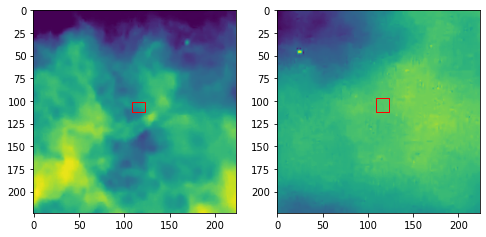

In [74]:
plt.figure(figsize=(8, 24))
for img, _ in test_dataset.take(1):
    o1, o2, o3 ,o4 = nmodel.predict(img)
    for i in range(2):
        plt.subplot(4, 2, i+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        xmin, ymin, xmax, ymax = o1[i]*224, o2[i]*224, o3[i]*224, o4[i]*224
        rect = Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), fill = False, color = 'red')
        ax = plt.gca()
        ax.axes.add_patch(rect)

In [67]:
history.history.keys()

dict_keys(['loss', 'dense_15_loss', 'dense_16_loss', 'dense_17_loss', 'dense_18_loss', 'dense_15_mae', 'dense_16_mae', 'dense_17_mae', 'dense_18_mae', 'val_loss', 'val_dense_15_loss', 'val_dense_16_loss', 'val_dense_17_loss', 'val_dense_18_loss', 'val_dense_15_mae', 'val_dense_16_mae', 'val_dense_17_mae', 'val_dense_18_mae'])

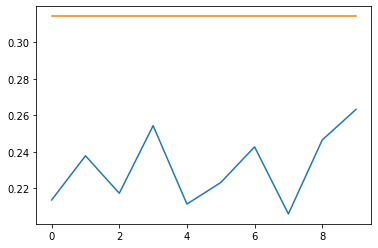

In [75]:
plt.plot(history.epoch, history.history.get('loss'), label = 'loss')
plt.plot(history.epoch, history.history.get('val_loss'), label = 'val_loss')